### DynamicBalanceClassSampler

[![Catalyst logo](https://raw.githubusercontent.com/catalyst-team/catalyst-pics/master/pics/catalyst_logo.png)](https://github.com/catalyst-team/catalyst)

This Notebook try to show the idea of DynamicBalanceClassSampler

In [1]:
import catalyst
import torch
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random

from catalyst.data.sampler import DynamicBalanceClassSampler
from catalyst.data.cv import ToTensor
from catalyst.contrib.datasets import MNIST
from collections import Counter
from typing import List, Any, Tuple
from catalyst.utils import set_global_seed

set_global_seed(42)

### Utils

Some usefull functions to plot distributions

In [2]:
def bar_chart(keys: List[Any], values: List[Any], figsize=None, ylabel=None,
              title=None, log_scale=False, *args):
    all_colors = list(plt.cm.colors.cnames.keys())
    random.seed(100)
    c = random.choices(all_colors, k=len(keys))
    
    if figsize:
        plt.figure(figsize=figsize, dpi=80)
    plt.bar(keys, values, color=c, width=.5)
    for i, val in enumerate(values):
        plt.text(i, val, float(val), horizontalalignment='center',
                 verticalalignment='bottom',
                 fontdict={'fontweight': 500, 'size': 12})
    plt.gca().set_xticklabels(keys, rotation=60, horizontalalignment= 'right', *args)
    
    if title:
        plt.title(title, fontsize=22)
    if log_scale:
        plt.yscale('log')
    if ylabel:
        plt.ylabel(ylabel)

In [3]:
def show_distribution(labels: np.array, figsize=None, title=None) -> None:
    distribution = Counter(labels)
    examples_per_class = [distribution[label] for label in range(10)]
    label_names = [f'class_{label}' for label in range(10)]
    bar_chart(label_names, examples_per_class, figsize, ylabel='examples', title=title)

__Problem__: Unfortunately, often datasets don't have uniform class distribution. Let's consider such a situation. The MNIST dataset was taken and made disbalance. 

In [4]:
class DisbalanceMNIST(MNIST):
    def __init__(self,  *args, **kwargs):
        super().__init__(*args, **kwargs)
        length = super().__len__()
        labels = []
        for idx in range(length):
            labels.append(super().__getitem__(idx)[1])
        labels = np.array(labels)
        
        label2idxes = {
            label: np.arange(len(labels))[labels == label].tolist()
            for label in set(labels)
        }
        
        label_0_size = len(label2idxes[0])
        label2example = {label: label_0_size // (2 * label + 1) for label in np.arange(10)}
        
        self.new_indexes = []
        for label, n_examples in label2example.items():
            self.new_indexes.extend(np.random.choice(label2idxes[label],
                                                     size=n_examples,
                                                     replace=False))
    
    def __len__(self) -> int:
        return len(self.new_indexes)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        new_idx = self.new_indexes[idx]
        return super().__getitem__(new_idx)

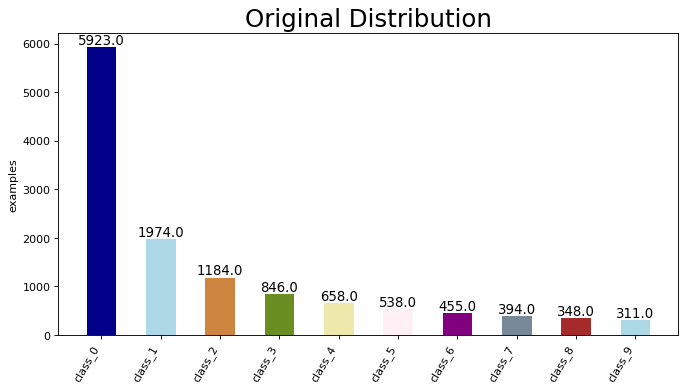

In [5]:
train_dataset = DisbalanceMNIST(root=os.getcwd(), train=True, download=True, transform=ToTensor())
train_labels = np.array([example[1] for example in train_dataset])
show_distribution(train_labels, (10, 5), title='Original Distribution')

Some classes are much larger than others, so if the model is trained using such dataset, it will cause overfitting. There are some common techniques: "downsampling", "upsampling". But they have some drawbacks:

1) If  "upsampling" is used all examples will be used but the model will see rare class (many times one example durion one epoch) too often, which can cause overfitting.

2) If "downsampling" is used, there will be no overfitting, but the model will not see a great number of examples, which can be very useful

DynamicBalanceClassSampler combines the advantages of these approaches. We start with the original distribution and step by step are going to a uniform distribution. On the one hand, the model will see all examples, and on the other hand at the end of the training there will be uniform distribution, so it will be no overfitting

__A Little Math explanation__:



Define schedule  $S_{exp}(epoch) = \lambda^{epoch}$, and $0 < \lambda < 1$. So this function is going from 1 on(epoch 0) to 0. 

After that calculate distribution coefficients $D_i = \dfrac{Size(C_i)}{Size(C_{min})}$, where $C_i$ defien $i$ class and $C_{min}$ define the rarest class. So all $D_i \geq 1$ and $D_{min} = 1$ 

On each epoch currecnt D are calculated: $D_{currecnt_i} = D_i^{S_{exp}(epoch)}$, as $S_{exp}(epoch) < 1$, $D_{currecnt_i} \leq D_{previous_i} \leq D_i$. It means that all $D_i$ are going to 1.

On each epoch we sample example by currecn $D$, using with formula: $D_{currecnt_i} \times Size(C_{min})$

__Some Notes:__

1) $\lambda$ - determines the rate of decrease

2) In the end of the training, epochs will contain only $Size(C_{min}) \times n_{classes}$  examples. So, possible it will not necessary to do validation on each epoch. For this reason use ControlFlowCallback.

Let's create it and see the result with our own eyes. Consider class distribution on different epochs

In [6]:
sampler = DynamicBalanceClassSampler(train_labels, exp_lambda=0.9, )

In [7]:
epoch_to_show = [1, 5, 15, 50]
epoch2labels = {}
for epoch in range(1, 51):
    epoch_indexes = np.array(list(sampler.__iter__()))
    if epoch in epoch_to_show:
        epoch2labels[epoch] = train_labels[np.array(epoch_indexes)]

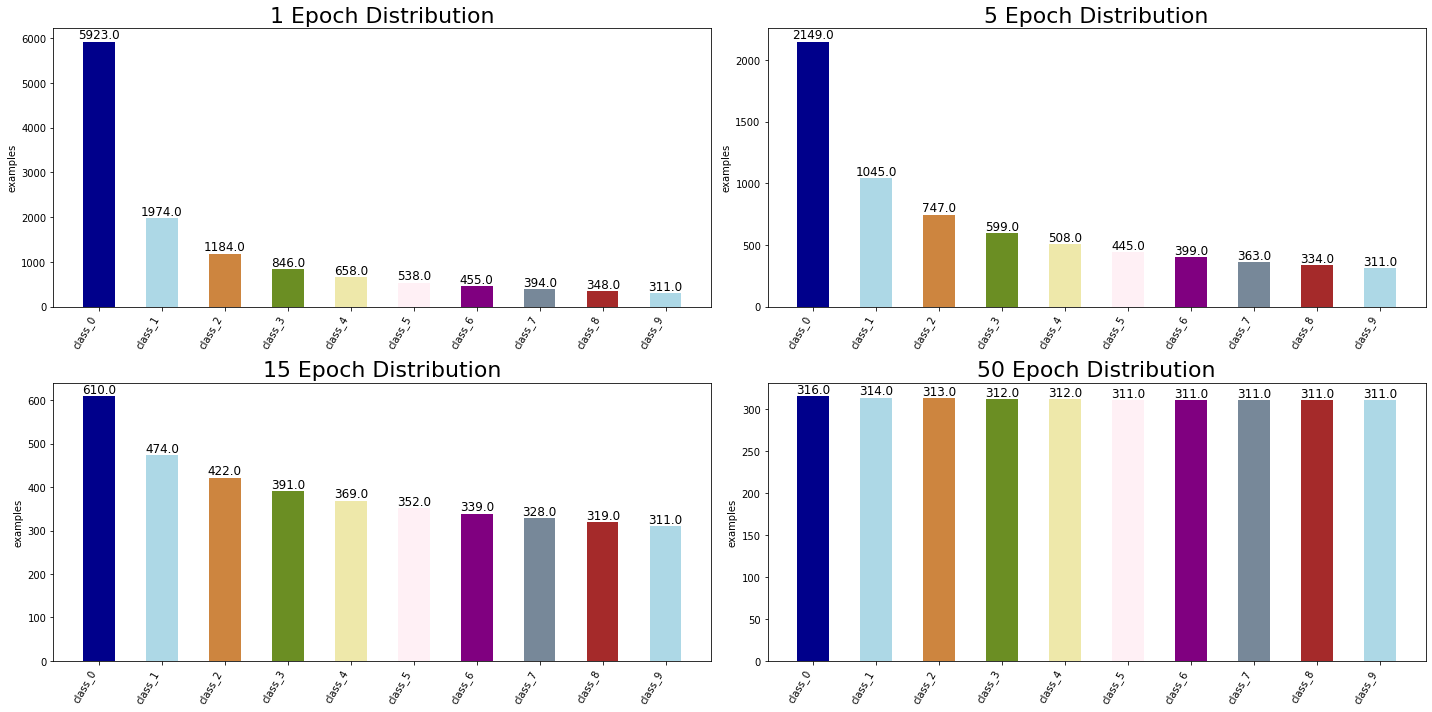

In [8]:
fig = plt.figure(figsize = (20, 10))

for idx, (epoch, labels) in enumerate(epoch2labels.items(), start=1):
    plt.subplot(2, 2, idx)
    show_distribution(labels, None, title=f'{epoch} Epoch Distribution')
    plt.tight_layout(w_pad=1, h_pad=1)
plt.show()

Let's take a closer look at the parameters of this sampler:

__max_d:__ You can use it to control class imbalance. If it is not None, $D_{currecnt_i} = min(D_i^{S_{exp}(epoch)}, max_d)$, so you can avoid too strong disbalance

__mode:__ In some cases, you may want a different target class size for them to aim for. You can specify it explicitly



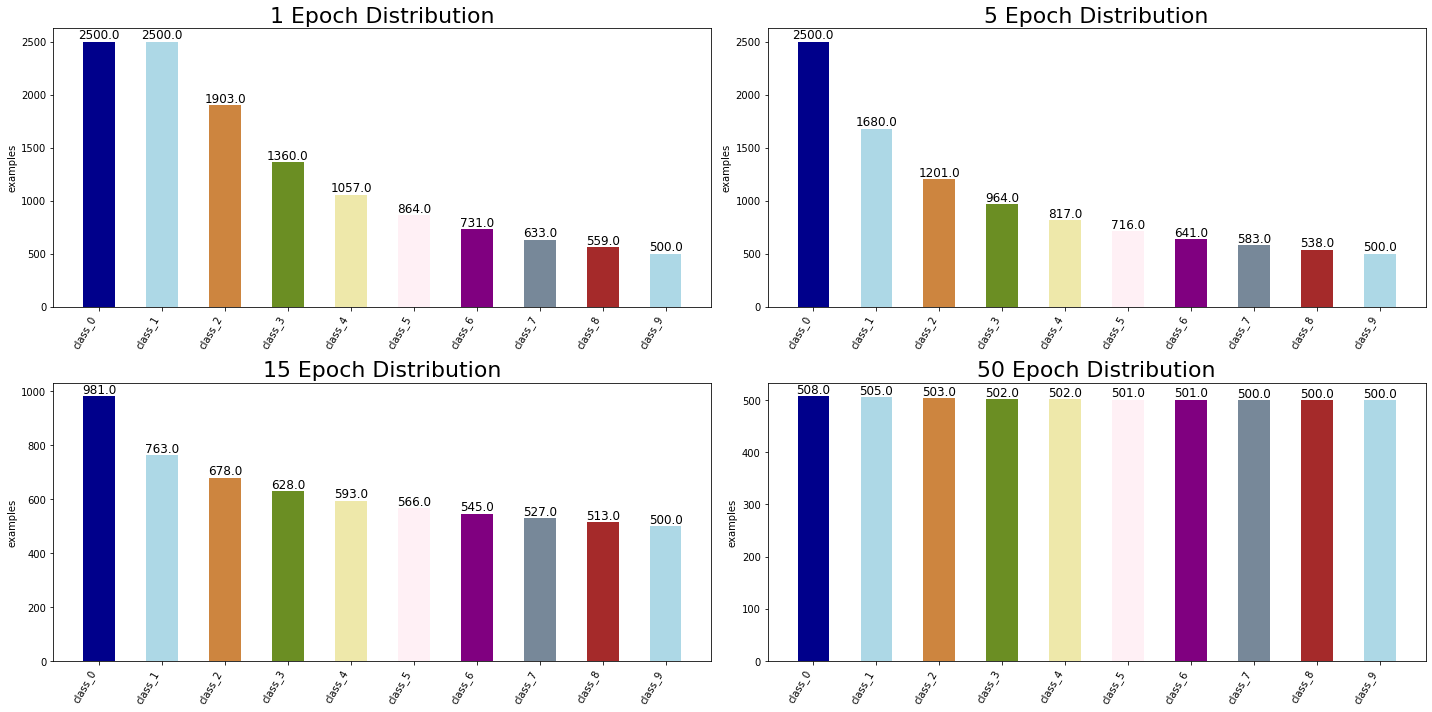

In [9]:
sampler = DynamicBalanceClassSampler(train_labels, exp_lambda=0.9, max_d=5, mode=500)

epoch_to_show = [1, 5, 15, 50]
epoch2labels = {}
for epoch in range(1, 51):
    epoch_indexes = np.array(list(sampler.__iter__()))
    if epoch in epoch_to_show:
        epoch2labels[epoch] = train_labels[np.array(epoch_indexes)]

fig = plt.figure(figsize = (20, 10))

for idx, (epoch, labels) in enumerate(epoch2labels.items(), start=1):
    plt.subplot(2, 2, idx)
    show_distribution(labels, None, title=f'{epoch} Epoch Distribution')
    plt.tight_layout(w_pad=1, h_pad=1)
plt.show()

We see that:

1) the most popular class is only 5 times larger than the smallest.

2) All classes go to a new balance of 500

We hope that this notebook will be useful for you!